In [11]:
import pandas as pd  
import numpy as np
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer
plt.style.use('fivethirtyeight')

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [2]:
csv = 'clean_tweet.csv'
my_df = pd.read_csv(csv,index_col=0)
my_df.head()

C:\Users\varru\Anaconda3\lib\site-packages\numpy\lib\arraysetops.py:395: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


,text,target
0,awww that bummer you shoulda got david carr of...,0
1,is upset that he can not update his facebook b...,0
2,dived many times for the ball managed to save ...,0
3,my whole body feels itchy and like its on fire,0
4,no it not behaving at all mad why am here beca...,0


In [3]:
my_df.dropna(inplace=True)
my_df.reset_index(drop=True,inplace=True)
my_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1596041 entries, 0 to 1596040
Data columns (total 2 columns):
text      1596041 non-null object
target    1596041 non-null int64
dtypes: int64(1), object(1)
memory usage: 24.4+ MB


In [4]:
x = my_df.text
y = my_df.target

In [5]:
from sklearn.cross_validation import train_test_split
SEED = 2000
x_train, x_validation_and_test, y_train, y_validation_and_test = train_test_split(x, y, test_size=.02, random_state=SEED)
x_validation, x_test, y_validation, y_test = train_test_split(x_validation_and_test, y_validation_and_test, test_size=.5, random_state=SEED)

C:\Users\varru\Anaconda3\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [6]:
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from time import time

In [8]:
def accuracy_summary(pipeline, x_train, y_train, x_test, y_test):
    if len(x_test[y_test == 0]) / (len(x_test)*1.) > 0.5:
        null_accuracy = len(x_test[y_test == 0]) / (len(x_test)*1.)
    else:
        null_accuracy = 1. - (len(x_test[y_test == 0]) / (len(x_test)*1.))
    t0 = time()
    sentiment_fit = pipeline.fit(x_train, y_train)
    y_pred = sentiment_fit.predict(x_test)
    train_test_time = time() - t0
    accuracy = accuracy_score(y_test, y_pred)
    print ("null accuracy: {0:.2f}%".format(null_accuracy*100))
    print ("accuracy score: {0:.2f}%".format(accuracy*100))
    if accuracy > null_accuracy:
        print ("model is {0:.2f}% more accurate than null accuracy".format((accuracy-null_accuracy)*100))
    elif accuracy == null_accuracy:
        print ("model has the same accuracy with the null accuracy")
    else:
        print ("model is {0:.2f}% less accurate than null accuracy".format((null_accuracy-accuracy)*100))
    print ("train and test time: {0:.2f}s".format(train_test_time))
    print ("-"*80)
    return accuracy, train_test_time

In [12]:
cvec = CountVectorizer()
lr = LogisticRegression()
n_features = np.arange(10000,100001,10000)

def nfeature_accuracy_checker(vectorizer=cvec, n_features=n_features, stop_words=None, ngram_range=(1, 1), classifier=lr):
    result = []
    print (classifier)
    print ("\n")
    for n in n_features:
        vectorizer.set_params(stop_words=stop_words, max_features=n, ngram_range=ngram_range)
        checker_pipeline = Pipeline([
            ('vectorizer', vectorizer),
            ('classifier', classifier)
        ])
        print ("Validation result for {} features".format(n))
        nfeature_accuracy,tt_time = accuracy_summary(checker_pipeline, x_train, y_train, x_validation, y_validation)
        result.append((n,nfeature_accuracy,tt_time))
    return result

### TFIDF Vectorizer

TF-IDF is another way to convert textual data to a numeric form and is short for Term Frequency-Inverse Document Frequency. The vector value it yields is the product of these two terms; TF and IDF.

Let's first look at Term Frequency. We have already looked at term frequency above with count vectorizer, but this time, we need one more step to calculate the relative frequency. Let's say we have two documents in total as below.

1. I love dogs
2. I hate dogs and knitting

Relative term frequency is calculated for each term within each document as below.

$${TF(t,d)} = \frac {number\ of\ times\ term(t)\ appears\ in\ document(d)}{total\ number\ of\ terms\ in\ document(d)}$$

For example, if we calculate relative term frequency for 'I' in both document 1 and document 2, it will be as below.

$${TF('I',d1)} = \frac {1}{3} \approx {0.33}$$

$${TF('I',d2)} = \frac {1}{5} = {0.2}$$

Next, we need to get Inverse Document Frequency, which measures how important a word is to differentiate each document by following the calculation as below.

$${IDF(t,D)} = \log \Big(\frac {total\ number\ of\ documents(D)}{number\ of\ documents\ with\ the\ term(t)\ in\ it}\Big)$$

If we calculate inverse document frequency for 'I',

$${IDF('I',D)} = \log \Big(\frac {2}{2}\Big) = {0}$$

Once we have the values for TF and IDF, now we can calculate TFIDF as below.

$${TFIDF(t,d,D)} = {TF(t,d)}\cdot{IDF(t,D)}$$

Following the case of our example, TFIDF for term 'I' in both documents will be as below.

$${TFIDF('I',d1,D)} = {TF('I',d1)}\cdot{IDF('I',D)} = {0.33}\times{0} = {0}$$

$${TFIDF('I',d2,D)} = {TF('I',d2)}\cdot{IDF('I',D)} = {0.2}\times{0} = {0}$$

As you can see, the term 'I' appeared equally in both documents, and the TFIDF score is 0, which means the term is not really informative in differentiating documents. The rest is same as count vectorizer, TFIDF vectorizer will calculate these scores for terms in documents, and convert textual data into a numeric form.

In [13]:
from sklearn.feature_extraction.text import TfidfVectorizer
tvec = TfidfVectorizer()

In [15]:
%%time
print ("RESULT FOR UNIGRAM WITH STOP WORDS (Tfidf)\n")
feature_result_ugt = nfeature_accuracy_checker(vectorizer=tvec)

RESULT FOR UNIGRAM WITH STOP WORDS (Tfidf)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)


Validation result for 10000 features
null accuracy: 50.55%
accuracy score: 79.74%
model is 29.19% more accurate than null accuracy
train and test time: 61.45s
--------------------------------------------------------------------------------
Validation result for 20000 features
null accuracy: 50.55%
accuracy score: 80.03%
model is 29.48% more accurate than null accuracy
train and test time: 55.07s
--------------------------------------------------------------------------------
Validation result for 30000 features
null accuracy: 50.55%
accuracy score: 80.19%
model is 29.65% more accurate than null accuracy
train and test time: 68.67s
--------------------------------------------------

In [16]:
%%time
print ("RESULT FOR BIGRAM WITH STOP WORDS (Tfidf)\n")
feature_result_bgt = nfeature_accuracy_checker(vectorizer=tvec,ngram_range=(1, 2))

RESULT FOR BIGRAM WITH STOP WORDS (Tfidf)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)


Validation result for 10000 features
null accuracy: 50.55%
accuracy score: 80.71%
model is 30.16% more accurate than null accuracy
train and test time: 100.06s
--------------------------------------------------------------------------------
Validation result for 20000 features
null accuracy: 50.55%
accuracy score: 81.55%
model is 31.00% more accurate than null accuracy
train and test time: 102.07s
--------------------------------------------------------------------------------
Validation result for 30000 features
null accuracy: 50.55%
accuracy score: 81.95%
model is 31.40% more accurate than null accuracy
train and test time: 106.11s
------------------------------------------------

In [17]:
%%time
print ("RESULT FOR TRIGRAM WITH STOP WORDS (Tfidf)\n")
feature_result_tgt = nfeature_accuracy_checker(vectorizer=tvec,ngram_range=(1, 3))

RESULT FOR TRIGRAM WITH STOP WORDS (Tfidf)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)


Validation result for 10000 features
null accuracy: 50.55%
accuracy score: 80.73%
model is 30.18% more accurate than null accuracy
train and test time: 185.66s
--------------------------------------------------------------------------------
Validation result for 20000 features
null accuracy: 50.55%
accuracy score: 81.55%
model is 31.01% more accurate than null accuracy
train and test time: 190.70s
--------------------------------------------------------------------------------
Validation result for 30000 features
null accuracy: 50.55%
accuracy score: 81.95%
model is 31.41% more accurate than null accuracy
train and test time: 187.27s
-----------------------------------------------

It seems like TFIDF vectorizer is yielding better results when fed to logistic regression. Let's plot the results from count vectorizer together with TFIDF vectorizer.

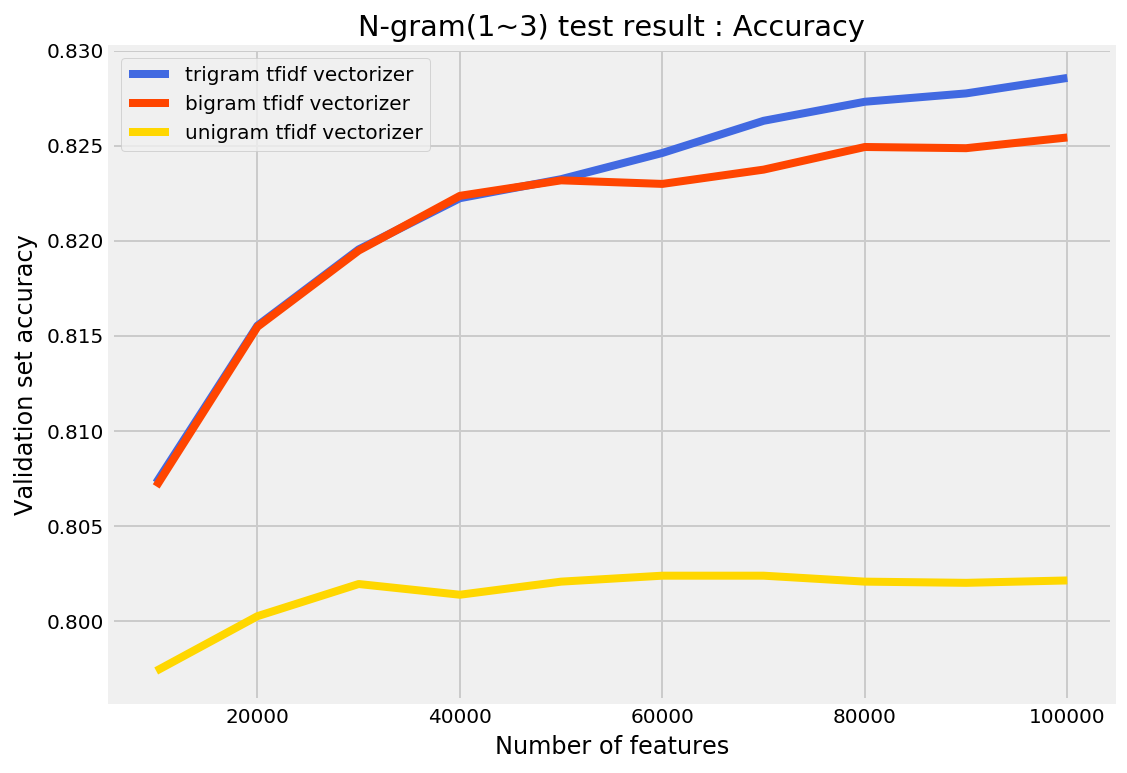

In [19]:
nfeatures_plot_tgt = pd.DataFrame(feature_result_tgt,columns=['nfeatures','validation_accuracy','train_test_time'])
nfeatures_plot_bgt = pd.DataFrame(feature_result_bgt,columns=['nfeatures','validation_accuracy','train_test_time'])
nfeatures_plot_ugt = pd.DataFrame(feature_result_ugt,columns=['nfeatures','validation_accuracy','train_test_time'])

plt.figure(figsize=(8,6))
plt.plot(nfeatures_plot_tgt.nfeatures, nfeatures_plot_tgt.validation_accuracy,label='trigram tfidf vectorizer',color='royalblue')
#plt.plot(nfeatures_plot_tg.nfeatures, nfeatures_plot_tg.validation_accuracy,label='trigram count vectorizer',linestyle=':', color='royalblue')
plt.plot(nfeatures_plot_bgt.nfeatures, nfeatures_plot_bgt.validation_accuracy,label='bigram tfidf vectorizer',color='orangered')
#plt.plot(nfeatures_plot_bg.nfeatures, nfeatures_plot_bg.validation_accuracy,label='bigram count vectorizer',linestyle=':',color='orangered')
plt.plot(nfeatures_plot_ugt.nfeatures, nfeatures_plot_ugt.validation_accuracy, label='unigram tfidf vectorizer',color='gold')
#plt.plot(nfeatures_plot_ug.nfeatures, nfeatures_plot_ug.validation_accuracy, label='unigram count vectorizer',linestyle=':',color='gold')
plt.title("N-gram(1~3) test result : Accuracy")
plt.xlabel("Number of features")
plt.ylabel("Validation set accuracy")
plt.legend()

From above chart, we can see including bigram and trigram boost the model performance both in count vectorizer and TFIDF vectorizer. And for every case of unigram to trigram, TFIDF yields better results than count vectorizer.

## Algorithms Comparison

The best result I can get with logistic regression was by using TFIDF vectorizer of 100,000 features including up to trigram. With this I will first fit various different models and compare their validation results, then I will build an ensemble (voting) classifier with top 5 models.

I haven't included some of computationally expensive models, such as KNN, random forest, considering the size of data and the scalability of models. And the fine-tuning of models will come after I try some other different vectorisation of textual data.

In [20]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import MultinomialNB, BernoulliNB
from sklearn.linear_model import RidgeClassifier
from sklearn.linear_model import PassiveAggressiveClassifier
from sklearn.linear_model import Perceptron
from sklearn.neighbors import NearestCentroid
from sklearn.feature_selection import SelectFromModel

names = ["Logistic Regression", "Linear SVC", "LinearSVC with L1-based feature selection","Multinomial NB", 
         "Bernoulli NB", "Ridge Classifier", "AdaBoost", "Perceptron","Passive-Aggresive", "Nearest Centroid"]
classifiers = [
    LogisticRegression(),
    LinearSVC(),
    Pipeline([
  ('feature_selection', SelectFromModel(LinearSVC(penalty="l1", dual=False))),
  ('classification', LinearSVC(penalty="l2"))]),
    MultinomialNB(),
    BernoulliNB(),
    RidgeClassifier(),
    AdaBoostClassifier(),
    Perceptron(),
    PassiveAggressiveClassifier(),
    NearestCentroid()
    ]
zipped_clf = zip(names,classifiers)

In [23]:
tvec = TfidfVectorizer()
def classifier_comparator(vectorizer=tvec, n_features=10000, stop_words=None, ngram_range=(1, 1), classifier=zipped_clf):
    result = []
    vectorizer.set_params(stop_words=stop_words, max_features=n_features, ngram_range=ngram_range)
    for n,c in classifier:
        checker_pipeline = Pipeline([
            ('vectorizer', vectorizer),
            ('classifier', c)
        ])
        print ("Validation result for {}".format(n))
        print (c)
        clf_accuracy,tt_time = accuracy_summary(checker_pipeline, x_train, y_train, x_validation, y_validation)
        result.append((n,clf_accuracy,tt_time))
    return result

In [24]:
%%time
trigram_result = classifier_comparator(n_features=100000,ngram_range=(1,3))

Validation result for Logistic Regression
LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)
null accuracy: 50.55%
accuracy score: 82.86%
model is 32.31% more accurate than null accuracy
train and test time: 175.91s
--------------------------------------------------------------------------------
Validation result for Linear SVC
LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
     verbose=0)
null accuracy: 50.55%
accuracy score: 82.09%
model is 31.55% more accurate than null accuracy
train and test time: 585.60s
--------------------------------------------------------------------------------
Validation result for LinearSVC with 

C:\Users\varru\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.perceptron.Perceptron'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


null accuracy: 50.55%
accuracy score: 75.93%
model is 25.38% more accurate than null accuracy
train and test time: 125.88s
--------------------------------------------------------------------------------
Validation result for Passive-Aggresive
PassiveAggressiveClassifier(C=1.0, average=False, class_weight=None,
              fit_intercept=True, loss='hinge', max_iter=None, n_iter=None,
              n_jobs=1, random_state=None, shuffle=True, tol=None,
              verbose=0, warm_start=False)


C:\Users\varru\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.passive_aggressive.PassiveAggressiveClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


null accuracy: 50.55%
accuracy score: 79.52%
model is 28.97% more accurate than null accuracy
train and test time: 166.28s
--------------------------------------------------------------------------------
Validation result for Nearest Centroid
NearestCentroid(metric='euclidean', shrink_threshold=None)
null accuracy: 50.55%
accuracy score: 73.18%
model is 22.64% more accurate than null accuracy
train and test time: 173.53s
--------------------------------------------------------------------------------
Wall time: 54min 48s


In [25]:
from sklearn.ensemble import VotingClassifier

clf1 = LogisticRegression()
clf2 = LinearSVC()
clf3 = MultinomialNB()
clf4 = RidgeClassifier()
clf5 = PassiveAggressiveClassifier()

eclf = VotingClassifier(estimators=[('lr', clf1), ('svc', clf2), ('mnb', clf3), ('rcs', clf4), ('pac', clf5)], voting='hard')

for clf, label in zip([clf1, clf2, clf3, clf4, clf5, eclf], ['Logistic Regression', 'Linear SVC', 'Multinomial NB', 'Ridge Classifier', 'Passive Aggresive Classifier', 'Ensemble']):
    checker_pipeline = Pipeline([
            ('vectorizer', TfidfVectorizer(max_features=100000,ngram_range=(1, 3))),
            ('classifier', clf)
        ])
    print ("Validation result for {}".format(label))
    print (clf)
    clf_accuracy,tt_time = accuracy_summary(checker_pipeline, x_train, y_train, x_validation, y_validation)

SyntaxError: invalid syntax (<ipython-input-25-11fd4622d5db>, line 16)

It seems like the voting classifier does no better than the simple logistic regression model. Thus later part, I will try to finetune logistic regression model. But before that, I would like to try another method of sentiment classification.